In [1]:
import numpy as np 
import pandas as pd
from pandas import DataFrame as df
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import math
import ray
ray.init(num_cpus= 10, ignore_reinit_error=True)

2023-04-04 14:04:17,437	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.2.0


In [2]:
master_data = pd.read_csv("jiadata2R.csv")
master_data.head(10)

,county,population,SPC,urban,MidWest,dBenton,southern,Kmart,WalMart,smallstores,dKmart,dWMart,X1,X2,X3,count0,count1,count2,nfirms
0,1.0,3.72,8.62,0.55,0.0,6.23,1.0,1.0,1.0,5.0,0.03,0.03,0.0,0.03,0.14,0,0,1,2
1,3.0,3.29,8.24,0.29,0.0,6.39,1.0,0.0,1.0,6.0,0.02,0.02,1.0,0.06,0.14,0,1,0,1
2,4.0,2.93,7.86,0.19,0.0,6.15,1.0,0.0,1.0,1.0,0.09,0.09,1.0,0.05,0.08,0,1,0,1
3,5.0,3.80,7.94,0.09,0.0,6.14,1.0,0.0,1.0,6.0,0.24,0.26,1.0,0.04,0.02,0,1,0,1
4,6.0,2.43,7.71,0.35,0.0,6.34,1.0,0.0,0.0,3.0,0.06,0.06,0.0,0.05,0.21,1,0,0,0
5,7.0,3.08,8.33,0.25,0.0,6.29,1.0,0.0,1.0,6.0,0.02,0.02,1.0,0.02,0.12,0,1,0,1
6,9.0,3.60,8.21,0.50,0.0,6.32,1.0,0.0,1.0,5.0,0.11,0.11,1.0,0.07,0.19,0,1,0,1
7,10.0,3.07,8.18,0.00,0.0,6.24,1.0,1.0,0.0,6.0,0.14,0.14,0.0,0.16,0.24,0,1,0,1
8,11.0,3.59,8.35,0.12,0.0,6.20,1.0,0.0,1.0,7.0,0.03,0.05,1.0,0.07,0.14,0,1,0,1
9,12.0,2.77,7.91,0.00,0.0,6.12,1.0,0.0,0.0,5.0,0.03,0.03,0.0,0.00,0.11,1,0,0,0


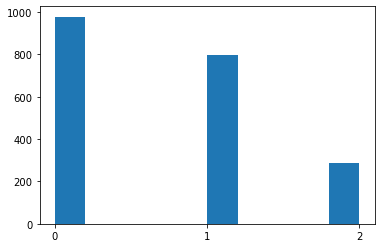

In [22]:
plt.hist(master_data['nfirms'])
plt.xticks([0,1,2], [0, 1, 2])
plt.show()

In [35]:
print("average population: ",master_data['population'].values.mean())
print("average SPC: ",master_data['SPC'].values.mean())
print("average urban: ",master_data['urban'].values.mean())

average population:  2.977859564164649
average SPC:  8.202392251815981
average urban:  0.32718159806295405


# Model 1. Bresnahan and Reiss

In [59]:
def model_1(theta):
    alpha_0, alpha_1, alpha_2, alpha_3, alpha_4 = theta
    delta = np.exp(alpha_4)

    def prob_calculator(population, SPC, urban):
        profit_M = np.array([alpha_0, alpha_1, alpha_2, alpha_3])@np.array([1, population, SPC, urban])
        profit_D = profit_M - delta
        
        prob_n2 = norm.cdf(profit_D, loc=0, scale=1)**2   # square(prob of being profitable under duopoly)
        prob_n0 = norm.cdf(-profit_M, loc=0, scale=1)**2  # square(prob of being unprofitable under monopoly)
        prob_n1 = 1 - prob_n2 - prob_n0

        return prob_n0, prob_n1, prob_n2
    vec_prob_calculator = np.vectorize(prob_calculator)
    prob_result = vec_prob_calculator(master_data['population'].values, master_data['SPC'].values, master_data['urban'].values)

    count0 = master_data['count0'].values
    count1 = master_data['count1'].values
    count2 = master_data['count2'].values

    prob_array = count0*prob_result[0] + count1*prob_result[1] + count2*prob_result[2]
    ln_prob_array = np.log(prob_array)
    ln_sum = ln_prob_array.sum()

    return -ln_sum

In [56]:
MLE_result = minimize(model_1, [-10, 1, 1, 1, 0], method='L-BFGS-B', options={'maxiter':200})

In [61]:
print("constant term: ", MLE_result.x[0])
print("effect of population term: ", MLE_result.x[1])
print("effect of SPC term: ", MLE_result.x[2])
print("effect of Urban term: ", MLE_result.x[3])
print("effect of competition: ", np.exp(MLE_result.x[4]))

constant term:  -14.035019742231885
effect of population term:  1.3248206743346689
effect of SPC term:  1.1256237416107922
effect of Urban term:  1.0286253511549457
effect of competition:  0.6536059296828228


# Model 2. Berry

## (1) WalMart Moves First

In [153]:
# W moves first
def model_2_W_first(theta): 
    c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = theta
    delta = np.exp(c_delta)

    duopoly_array = master_data['Kmart'].values * master_data['WalMart'].values
    Wmart_array = master_data['WalMart'].values * (1-master_data['Kmart'].values)
    Kmart_array = master_data['Kmart'].values * (1-master_data['WalMart'].values)
    none_array = 1 - duopoly_array - Wmart_array - Kmart_array

    pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
    pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_midwest*master_data['MidWest']

    #(1) Prob of two firm entry
    prob_duopoly = norm.cdf(pi_W - delta) * norm.cdf(pi_K - delta)

    #(2) Prob of no firm
    prob_none = norm.cdf(-pi_W) * norm.cdf(-pi_K)

    #(3) Prob of Wmart
    prob_Wmart = norm.cdf(pi_W) * norm.cdf(-pi_K + delta)

    #(4) Prob of Kmart
    prob_Kmart = 1 - prob_duopoly - prob_none - prob_Wmart

    #(5) Associated target prob
    prob_target = duopoly_array*prob_duopoly + none_array*prob_none + Kmart_array*prob_Kmart + Wmart_array*prob_Wmart
    ln_prob = np.log(prob_target)

    return -ln_prob.sum()


In [154]:
MLE_result2 = minimize(model_2_W_first, [1.6, 1.5, 1.2, 0.4, -10, -1, 0.7, -19, 0.3], method='L-BFGS-B', options={'maxiter':200})

In [156]:
print("effect of population: ", MLE_result2.x[0])
print("effect of SPC: ", MLE_result2.x[1])
print("effect of Urban: ", MLE_result2.x[2])
print("effect of competition: ", np.exp(MLE_result2.x[3]))
print("effect of Walmart: ", MLE_result2.x[4])
print("effect of Distance to Benton: ", MLE_result2.x[5])
print("effect of Southern dummy: ", MLE_result2.x[6])
print("effect of Kmart: ", MLE_result2.x[7])
print("effect of MidWest dummy: ", MLE_result2.x[8])

effect of population:  1.677387916870161
effect of SPC:  1.5242629097150928
effect of Urban:  1.192068248895334
effect of competition:  0.39558286877952303
effect of Walmart:  -11.763169021251633
effect of Distance to Benton:  -1.0628658774812962
effect of Southern dummy:  0.7167316264950168
effect of Kmart:  -19.56880584277708
effect of MidWest dummy:  0.36926067970824145


## (2) Kmart Moves First

In [179]:
# W moves first
def model_2_K_first(theta): 
    c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = theta
    delta = np.exp(c_delta)

    duopoly_array = master_data['Kmart'].values * master_data['WalMart'].values
    Wmart_array = master_data['WalMart'].values * (1-master_data['Kmart'].values)
    Kmart_array = master_data['Kmart'].values * (1-master_data['WalMart'].values)
    none_array = 1 - duopoly_array - Wmart_array - Kmart_array

    pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
    pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_midwest*master_data['MidWest']

    #(1) Prob of two firm entry
    prob_duopoly = norm.cdf(pi_W - delta) * norm.cdf(pi_K - delta)

    #(2) Prob of no firm
    prob_none = norm.cdf(-pi_W) * norm.cdf(-pi_K)

    #(3) Prob of Wmart
    prob_Kmart = norm.cdf(pi_K) * norm.cdf(-pi_W + delta)

    #(4) Prob of Kmart
    prob_Wmart = 1 - prob_duopoly - prob_none - prob_Kmart

    #(5) Associated target prob
    prob_target = duopoly_array*prob_duopoly + none_array*prob_none + Kmart_array*prob_Kmart + Wmart_array*prob_Wmart
    prob_target = np.where(prob_target <= 0, 0.00001, prob_target)
    ln_prob = np.log(prob_target)

    return -ln_prob.sum()


In [180]:
MLE_result3 = minimize(model_2_K_first, [1.7, 1.5, 1.2, 0.4, -12, -1, 0.7, -19, 0.3], method='L-BFGS-B', options={'maxiter':200})

In [181]:
print("effect of population: ", MLE_result3.x[0])
print("effect of SPC: ", MLE_result3.x[1])
print("effect of Urban: ", MLE_result3.x[2])
print("effect of competition: ", np.exp(MLE_result3.x[3]))
print("effect of Walmart: ", MLE_result3.x[4])
print("effect of Distance to Benton: ", MLE_result3.x[5])
print("effect of Southern dummy: ", MLE_result3.x[6])
print("effect of Kmart: ", MLE_result3.x[7])
print("effect of MidWest dummy: ", MLE_result3.x[8])

effect of population:  1.6890475161420677
effect of SPC:  1.539843602383923
effect of Urban:  1.2058371750910133
effect of competition:  0.38213066157173486
effect of Walmart:  -11.89495257597386
effect of Distance to Benton:  -1.065483560023668
effect of Southern dummy:  0.712521304139117
effect of Kmart:  -19.784841567886517
effect of MidWest dummy:  0.3666154926246454


# Model 3. NFXP

In [210]:
def model_3_NFXP(theta): 
    epsilon = 0.000000000000001
    alpha = 1
    c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = theta
    delta = np.exp(c_delta)

    pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
    pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_midwest*master_data['MidWest']

    pw_pre = np.full(2065,0.5)
    pk_pre = np.full(2065,0.5)

    while True:
        pw_post = alpha*norm.cdf(pi_K - delta*pk_pre) + (1-alpha)*pw_pre
        pk_post = alpha*norm.cdf(pi_W - delta*pw_pre) + (1-alpha)*pk_pre

        pw_criterion = (abs(pw_post - pw_pre)).max()
        pk_criterion = (abs(pk_post - pk_pre)).max()
        
        if max(pw_criterion, pk_criterion) < epsilon:
            break
        else: 
            pw_pre = pw_post
            pk_pre = pk_post

    prob_Wmart = master_data['WalMart'].values*np.log(pw_post) + (1-master_data['WalMart'].values)*np.log(1-pw_post)
    prob_Kmart = master_data['Kmart'].values*np.log(pk_post) + (1-master_data['Kmart'].values)*np.log(1-pk_post)

    ln_sum = prob_Wmart + prob_Kmart

    return -ln_sum.sum()


In [211]:
MLE_result4 = minimize(model_3_NFXP, [1.7, 1.5, 1.2, 0.4, -12, -1, 0.7, -19, 0.3], method='Nelder-Mead', options={'maxiter':200})

In [212]:
print("effect of population: ", MLE_result4.x[0])
print("effect of SPC: ", MLE_result4.x[1])
print("effect of Urban: ", MLE_result4.x[2])
print("effect of competition: ", np.exp(MLE_result4.x[3]))
print("effect of Walmart: ", MLE_result4.x[4])
print("effect of Distance to Benton: ", MLE_result4.x[5])
print("effect of Southern dummy: ", MLE_result4.x[6])
print("effect of Kmart: ", MLE_result4.x[7])
print("effect of MidWest dummy: ", MLE_result4.x[8])

effect of population:  1.879557899549483
effect of SPC:  1.869429398653214
effect of Urban:  -0.8764371473430544
effect of competition:  1.3109135882430365
effect of Walmart:  -24.868096878990876
effect of Distance to Benton:  0.5206325052149736
effect of Southern dummy:  0.3684754690116696
effect of Kmart:  -20.58632323182482
effect of MidWest dummy:  -0.13408899863221738


# Model 4. 2step

In [213]:
import statsmodels.api as sm

In [227]:
Kmart_data = master_data.copy()
Kmart_data['interaction_1'] = Kmart_data['population'].values * Kmart_data['SPC']
Kmart_data['interaction_2'] = Kmart_data['population'].values * Kmart_data['urban']
Kmart_data['interaction_3'] = Kmart_data['population'].values * Kmart_data['MidWest']
Kmart_data['interaction_4'] = Kmart_data['SPC'].values * Kmart_data['urban']
Kmart_data['interaction_5'] = Kmart_data['SPC'].values * Kmart_data['MidWest']
Kmart_data['interaction_6'] = Kmart_data['urban'].values * Kmart_data['MidWest']
Kmart_binom = sm.GLM(Kmart_data['Kmart'], Kmart_data[['population','SPC','urban', 'MidWest', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'interaction_5', 'interaction_6']], family = sm.families.Binomial())
Kmart_res = Kmart_binom.fit()
Kmart_first_stage = Kmart_res.predict(Kmart_data[['population','SPC','urban', 'MidWest', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'interaction_5', 'interaction_6']])

In [228]:
Wmart_data = master_data.copy()
Wmart_data['interaction_1'] = Wmart_data['population'].values * Wmart_data['SPC']
Wmart_data['interaction_2'] = Wmart_data['population'].values * Wmart_data['urban']
Wmart_data['interaction_3'] = Wmart_data['population'].values * Wmart_data['dBenton']
Wmart_data['interaction_4'] = Wmart_data['population'].values * Wmart_data['southern']
Wmart_data['interaction_5'] = Wmart_data['SPC'].values * Wmart_data['urban']
Wmart_data['interaction_6'] = Wmart_data['SPC'].values * Wmart_data['dBenton']
Wmart_data['interaction_7'] = Wmart_data['SPC'].values * Wmart_data['southern']
Wmart_data['interaction_8'] = Wmart_data['urban'].values * Wmart_data['dBenton']
Wmart_data['interaction_9'] = Wmart_data['urban'].values * Wmart_data['southern']
Wmart_data['interaction_10'] = Wmart_data['dBenton'].values * Wmart_data['southern']
Wmart_binom = sm.GLM(Wmart_data['WalMart'], Wmart_data[['population','SPC','urban', 'dBenton', 'southern', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'interaction_5', 'interaction_6', 'interaction_7', 'interaction_8', 'interaction_9', 'interaction_10']], family = sm.families.Binomial())
Wmart_res = Wmart_binom.fit()
Wmart_first_stage = Wmart_res.predict(Wmart_data[['population','SPC','urban', 'dBenton', 'southern', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'interaction_5', 'interaction_6', 'interaction_7', 'interaction_8', 'interaction_9', 'interaction_10']])

In [230]:
master_data['prob_K_first'] = Kmart_first_stage
master_data['prob_W_first'] = Wmart_first_stage

In [232]:
def model_4_2step(theta): 
    c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = theta
    delta = np.exp(c_delta)

    pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
    pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                     c_midwest*master_data['MidWest']

    pw_post = norm.cdf(pi_W - delta*master_data['prob_K_first'].values)
    pk_post = norm.cdf(pi_K - delta*master_data['prob_W_first'].values)

    prob_Wmart = master_data['WalMart'].values*np.log(pw_post) + (1-master_data['WalMart'].values)*np.log(1-pw_post)
    prob_Kmart = master_data['Kmart'].values*np.log(pk_post) + (1-master_data['Kmart'].values)*np.log(1-pk_post)

    ln_sum = prob_Wmart + prob_Kmart

    return -ln_sum.sum()


In [233]:
MLE_result5 = minimize(model_4_2step, [1.7, 1.5, 1.2, 0.4, -12, -1, 0.7, -19, 0.3], method='Nelder-Mead', options={'maxiter':200})

In [235]:
print("effect of population: ", MLE_result5.x[0])
print("effect of SPC: ", MLE_result5.x[1])
print("effect of Urban: ", MLE_result5.x[2])
print("effect of competition: ", np.exp(MLE_result5.x[3]))
print("effect of Walmart: ", MLE_result5.x[4])
print("effect of Distance to Benton: ", MLE_result5.x[5])
print("effect of Southern dummy: ", MLE_result5.x[6])
print("effect of Kmart: ", MLE_result5.x[7])
print("effect of MidWest dummy: ", MLE_result5.x[8])

effect of population:  1.9542927018744147
effect of SPC:  1.774016883282029
effect of Urban:  1.3527506046816755
effect of competition:  1.2626039384411514
effect of Walmart:  -14.489026465239222
effect of Distance to Benton:  -1.0819277206698352
effect of Southern dummy:  0.7435641693140882
effect of Kmart:  -22.06061896151596
effect of MidWest dummy:  0.3150992045612935


# Model 5. NPL

In [265]:
# initial condition
pw_pre = master_data['prob_W_first'].values
pk_pre = master_data['prob_K_first'].values

counter = 0
while (counter < 100):
    epsilon = 0.00000001

    
    # solve for optimal theta
    def model_5_NPL(theta): 
        c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = theta
        delta = np.exp(c_delta)

        pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                        c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
        pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                        c_midwest*master_data['MidWest']

        pw_plugin = norm.cdf(pi_W - delta*pw_pre)
        pk_plugin = norm.cdf(pi_K - delta*pk_pre)

        prob_Wmart = master_data['WalMart'].values*np.log(pw_plugin) + (1-master_data['WalMart'].values)*np.log(1-pw_plugin)
        prob_Kmart = master_data['Kmart'].values*np.log(pk_plugin) + (1-master_data['Kmart'].values)*np.log(1-pk_plugin)

        ln_sum = prob_Wmart + prob_Kmart

        return -ln_sum.sum()

    MLE_result6 = minimize(model_5_NPL, [1.7, 1.5, 1.2, 0.4, -12, -1, 0.7, -19, 0.3], method='Nelder-Mead', options={'maxiter':200})

    
    c_population, c_SPC, c_urban, c_delta, c_Wmart, c_benton, c_south, c_Kmart, c_midwest = MLE_result6.x

    pi_W = c_Wmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                    c_benton*master_data['dBenton'].values + c_south*master_data['southern'].values
    pi_K = c_Kmart + c_population*master_data['population'].values + c_SPC*master_data['SPC'] + c_urban*master_data['urban'] + \
                    c_midwest*master_data['MidWest']

    # update probability
    delta = np.exp(MLE_result6.x[3])
    pw_post = norm.cdf(pi_W - delta*pk_pre) 
    pk_post = norm.cdf(pi_K - delta*pw_pre) 

    pw_criterion = (abs(pw_post - pw_pre)).max()
    pk_criterion = (abs(pk_post - pk_pre)).max()
    
    if counter % 10 == 0:
        print(counter)

    if max(pw_criterion, pk_criterion) < epsilon:
        break
    else: 
        pw_pre = pw_post
        pk_pre = pk_post
        counter += 1 

0
10
20
30
40
50
60
70
80
90


In [267]:
print("effect of population: ", MLE_result6.x[0])
print("effect of SPC: ", MLE_result6.x[1])
print("effect of Urban: ", MLE_result6.x[2])
print("effect of competition: ", np.exp(MLE_result6.x[3]))
print("effect of Walmart: ", MLE_result6.x[4])
print("effect of Distance to Benton: ", MLE_result6.x[5])
print("effect of Southern dummy: ", MLE_result6.x[6])
print("effect of Kmart: ", MLE_result6.x[7])
print("effect of MidWest dummy: ", MLE_result6.x[8])

effect of population:  1.8785232190842747
effect of SPC:  1.68142930116211
effect of Urban:  1.887953936558132
effect of competition:  0.9944596037212455
effect of Walmart:  -12.908925053467751
effect of Distance to Benton:  -1.1396583767665263
effect of Southern dummy:  0.825064133276562
effect of Kmart:  -21.962056297837528
effect of MidWest dummy:  0.3475773853471218
